In [212]:
import os
TITANIC_PATH = os.path.join(os.getcwd(), "titanic")  # This ensures the correct absolute path


In [214]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [215]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [217]:

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [218]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [219]:

train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Okay, the Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The Name and Ticket attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [221]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [222]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [223]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [225]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Our preprocessing pipelines. DataframeSelector is used to select specific attributes from the DataFrame:

In [228]:

from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

By pipeline we easily apply to whole dataset.

By SimpleImputer, we fill nan places by median.

In [232]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [233]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns, the regular SimpleImputer does not work on those.

In [235]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Onehotencoder converts categorical values into 0 and 1

In [239]:
from sklearn.preprocessing import OneHotEncoder

In [241]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder()),
    ])


In [243]:
cat_pipeline.fit_transform(train_data)

<891x8 sparse matrix of type '<class 'numpy.float64'>'
	with 2673 stored elements in Compressed Sparse Row format>

Pipeline to apply num and cat functions

In [246]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


In [247]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

<891x12 sparse matrix of type '<class 'numpy.float64'>'
	with 4936 stored elements in Compressed Sparse Row format>

In [248]:
y_train = train_data["Survived"]

In [249]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [250]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [255]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274


Let's try a RandomForestClassifier:

In [258]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558


Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores .

Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is Q1 and the upper quartile is Q3, then the interquartile range IQR=Q3-Q1
 (this is the box's height), and any score lower than Q1-1.5 x IQR is a flier, and so is any score greater than Q3+1.5 x IQR.

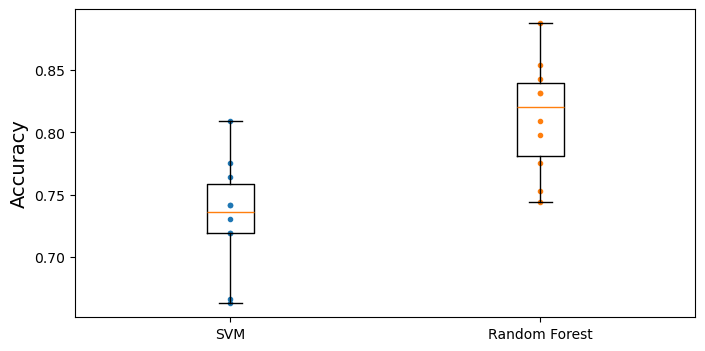

In [261]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further:

Compare many more models and tune hyperparameters using cross validation and grid search,
Do more feature engineering, 

for example:

replace SibSp and Parch with their sum,

try to identify parts of names that correlate well with the Survived attribute (e.g. if the name contains "Countess", then survival seems more likely),

try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [263]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [264]:

train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000



The attributes have the following meaning:

Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.

Pclass: passenger class.

Name, Sex, Age: self-explanatory

SibSp: how many siblings & spouses of the passenger aboard the Titanic.

Parch: how many children & parents of the passenger aboard the Titanic.

Ticket: ticket id

Fare: price paid (in pounds)

Cabin: passenger's cabin number

Embarked: where the passenger embarked the Titanic

-------------

In [268]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")


C:\Users\JYOTI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\JYOTI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic Regression: Mean Accuracy = 0.7913
Random Forest: Mean Accuracy = 0.8092
Gradient Boosting: Mean Accuracy = 0.8261
SVM: Mean Accuracy = 0.6746


Feature Engineering

Tune Hyperparameters Using Grid Search

In [269]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


Replace SibSp and Parch with FamilySize

In [270]:
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1  # Include self
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"] + 1


 Extract Titles from Names

In [325]:
train_data["Title"] = train_data["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_data["Title"] = test_data["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)


Group Rare Titles

In [327]:
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Rare", "Rev": "Rare", "Major": "Rare", "Col": "Rare",
    "Mlle": "Miss", "Mme": "Mrs", "Don": "Rare", "Countess": "Noble",
    "Lady": "Noble", "Sir": "Noble", "Jonkheer": "Noble", "Capt": "Rare"
}

train_data["Title"] = train_data["Title"].map(title_mapping)
test_data["Title"] = test_data["Title"].map(title_mapping)


Convert Age to Categories

In [278]:
train_data["AgeGroup"] = pd.cut(train_data["Age"], bins=[0, 12, 18, 35, 60, 100], labels=["Child", "Teen", "YoungAdult", "Adult", "Senior"])
test_data["AgeGroup"] = pd.cut(test_data["Age"], bins=[0, 12, 18, 35, 60, 100], labels=["Child", "Teen", "YoungAdult", "Adult", "Senior"])


"Traveling Alone" Feature

In [280]:
train_data["IsAlone"] = (train_data["FamilySize"] == 1).astype(int)
test_data["IsAlone"] = (test_data["FamilySize"] == 1).astype(int)


Encode Categorical Features

In [281]:
train_data = pd.get_dummies(train_data, columns=["Pclass", "Sex", "Embarked", "Title", "AgeGroup"], drop_first=True)
test_data = pd.get_dummies(test_data, columns=["Pclass", "Sex", "Embarked", "Title", "AgeGroup"], drop_first=True)


 Scale Numeric Features

In [282]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features = ["Age", "Fare", "FamilySize"]

train_data[num_features] = scaler.fit_transform(train_data[num_features])
test_data[num_features] = scaler.transform(test_data[num_features])


 Retrain and Evaluate

In [335]:
final_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

In [284]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")


C:\Users\JYOTI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\JYOTI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic Regression: Mean Accuracy = 0.7913
Random Forest: Mean Accuracy = 0.8092
Gradient Boosting: Mean Accuracy = 0.8261
SVM: Mean Accuracy = 0.6746


In [312]:
print(train_data)

     PassengerId  Survived                                               Name  \
0              1         0                            Braund, Mr. Owen Harris   
1              2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3         1                             Heikkinen, Miss. Laina   
3              4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5         0                           Allen, Mr. William Henry   
..           ...       ...                                                ...   
886          887         0                              Montvila, Rev. Juozas   
887          888         1                       Graham, Miss. Margaret Edith   
888          889         0           Johnston, Miss. Catherine Helen "Carrie"   
889          890         1                              Behr, Mr. Karl Howell   
890          891         0                                Dooley, Mr. Patrick   

          Age  SibSp  Parch